In [71]:
import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# Instantiate Convolutional Base
conv_base = tf.keras.applications.VGG16(
    # specifies the weight checkpoint from which to initialise the model
    weights='imagenet', 
    # refers to use/not use the densly connected classifier (which we are not)
    include_top=False, 
    # shape of the image tensors to be fed into the network
    input_shape=(150,150,3) )

In [75]:
# Listing of directories. Ensure images are loaded in the mentioned directories.
HOME_DIR = os.path.dirname(os.path.abspath('__FILE__'))
WORKSPACE_DIR = os.path.join(HOME_DIR, 'sample_data', 'workspace')

train_dir = os.path.join(WORKSPACE_DIR, 'train')
validation_dir = os.path.join(WORKSPACE_DIR, 'validation')
test_dir = os.path.join(WORKSPACE_DIR, 'test')

# TESTING: Validate the images in train & validation folder
catsdir = os.listdir(os.path.join(HOME_DIR, train_dir, 'cat'))
print(catsdir[:10])
print(len(catsdir))
dogssdir = os.listdir(os.path.join(HOME_DIR, train_dir, 'dog'))
print(dogssdir[:10])
print(len(dogssdir))
print()

catsdir2 = os.listdir(os.path.join(HOME_DIR, validation_dir, 'cat'))
print(catsdir2[:10])
print(len(catsdir2))
dogssdir2 = os.listdir(os.path.join(HOME_DIR, validation_dir, 'dog'))
print(dogssdir2[:10])
print(len(dogssdir2))
print()

catsdir3 = os.listdir(os.path.join(HOME_DIR, test_dir, 'cat'))
print(catsdir3[:10])
print(len(catsdir3))
dogssdir3 = os.listdir(os.path.join(HOME_DIR, test_dir, 'dog'))
print(dogssdir3[:10])
print(len(dogssdir3))

['77.jpg', '1187.jpg', '6574.jpg', '10320.jpg', '943.jpg', '2048.jpg', '7286.jpg', '7523.jpg', '9684.jpg', '3948.jpg']
1000
['77.jpg', '1187.jpg', '6574.jpg', '10320.jpg', '943.jpg', '2048.jpg', '7286.jpg', '7523.jpg', '9684.jpg', '3948.jpg']
1000

['1741.jpg', '6984.jpg', '9094.jpg', '9693.jpg', '5094.jpg', '4836.jpg', '8822.jpg', '5902.jpg', '565.jpg', '8759.jpg']
500
['1741.jpg', '6984.jpg', '9094.jpg', '9693.jpg', '5094.jpg', '4836.jpg', '8822.jpg', '5902.jpg', '565.jpg', '8759.jpg']
500

['3542.jpg', '6823.jpg', '2304.jpg', '3386.jpg', '6370.jpg', '10680.jpg', '7863.jpg', '6412.jpg', '8417.jpg', '7254.jpg']
500
['3542.jpg', '6823.jpg', '2304.jpg', '3386.jpg', '6370.jpg', '10680.jpg', '7863.jpg', '6412.jpg', '8417.jpg', '7254.jpg']
500


In [76]:
# MODEL 1: Feature Extraction
#############################

# Transform images to numpy arrays using the convolutional base
def extract_features(directory, sample_count):
    
    BATCH_SIZE = 20
    TARGET_SIZE = (150, 150)
    CLASS_MODE = 'binary'
    features = np.zeros(shape=(sample_count, 4,4,512))
    labels = np.zeros(shape=(sample_count))
    
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(directory, target_size=TARGET_SIZE,
                                           batch_size=BATCH_SIZE, class_mode=CLASS_MODE)
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = features_batch
        labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = labels_batch
        i+=1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels


train_features, train_labels = extract_features(train_dir, 2000)
train_features = np.reshape(train_features, (2000, 4*4*512))

val_features, val_labels = extract_features(validation_dir, 1000)
val_features = np.reshape(val_features, (1000, 4*4*512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [77]:
# MODEL 1: Instantiate Model
#########################################
model2a = tf.keras.models.Sequential()
model2a.add(tf.keras.layers.Dense(256, activation='relu', input_dim=4*4*512))
model2a.add(tf.keras.layers.Dropout(0.5))
model2a.add(tf.keras.layers.Dense(1, activation='sigmoid'))
print(model2a.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
# MODEL 1: Train Model & Evaluation
###################################
model2a.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5), 
              loss='binary_crossentropy', metrics=['accuracy'])
with tf.device('/device:GPU:0'):
    history2a = model2a.fit(train_features, train_labels, epochs=50, batch_size=20,
          validation_data=(val_features, val_labels))

Epoch 1/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0806 - accuracy: 0.9785 - val_loss: 0.2420 - val_accuracy: 0.8970
Epoch 2/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0763 - accuracy: 0.9795 - val_loss: 0.2398 - val_accuracy: 0.8960
Epoch 3/50
100/100 [==============================] - 0s 3ms/step - loss: 0.0737 - accuracy: 0.9810 - val_loss: 0.2296 - val_accuracy: 0.9040
Epoch 4/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0755 - accuracy: 0.9780 - val_loss: 0.2313 - val_accuracy: 0.9040
Epoch 5/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0726 - accuracy: 0.9795 - val_loss: 0.2391 - val_accuracy: 0.8970
Epoch 6/50
100/100 [==============================] - 0s 3ms/step - loss: 0.0648 - accuracy: 0.9870 - val_loss: 0.2330 - val_accuracy: 0.9060
Epoch 7/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0651 - accuracy: 0.9880 - val_loss: 0.2412 - val_accuracy: 0.8950
Epoch 

,loss,accuracy,val_loss,val_accuracy,epoch
45,0.013040,1.0000,0.293413,0.899,46
46,0.010287,1.0000,0.295604,0.899,47
47,0.010682,0.9995,0.326227,0.889,48
48,0.010119,0.9995,0.295048,0.897,49
49,0.008708,1.0000,0.308383,0.894,50


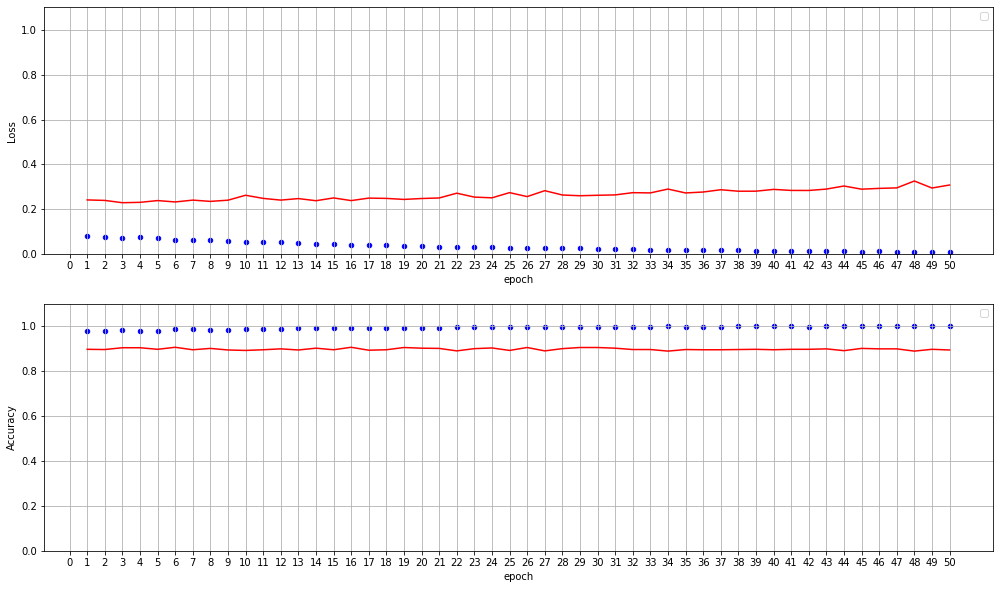

In [81]:
metrics_df = pd.DataFrame(history2a.history)
metrics_df['epoch'] = metrics_df.index+1
display(metrics_df.tail())

fig = plt.figure(figsize=(17,10))
ax1, ax2 = fig.add_subplot(2,1,1), fig.add_subplot(2,1,2)
metrics_df.plot(kind='scatter', x='epoch', y='loss', ax=ax1, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_loss', ax=ax1, label='validation', color='red',)
ax1.set_ylabel("Loss")
ax1.grid('GAINSBORO')
ax1.legend([])
ax1.set_ylim(0,1.1)
ax1.set_xticks(range(0,51))

metrics_df.plot(kind='scatter', x='epoch', y='accuracy', ax=ax2, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_accuracy', ax=ax2, label='validation', color='red',)
ax2.set_ylabel("Accuracy")
ax2.grid('GAINSBORO')
ax2.set_xticks(range(0,51))
ax2.legend([])
ax2.set_ylim(0,1.1)
plt.show()

In [0]:
# MODEL 2: Instantiate Model
############################
# Instantiate Convolutional Base
conv_base_b = tf.keras.applications.VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150,150,3) )

model2b = tf.keras.models.Sequential()
model2b.add(conv_base_b)
model2b.add(tf.keras.layers.Flatten())
model2b.add(tf.keras.layers.Dense(256, activation='relu'))
model2b.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [87]:
# Validate that the no. of trainable weights is more because of the conv_base
print(model2b.summary())
print(len(model2b.trainable_weights))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________
None
30


In [0]:
conv_base_b.trainable = False

In [90]:
print(len(model2b.trainable_weights))

4


In [91]:
# MODEL 2: Preprocessing of data before feeding to the model
############################################################
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, # 0 - 180 degrees to randomly rotate
    width_shift_range=0.2,  # ranges (as a fraction of total width/height)
    height_shift_range=0.2, # to randomly translate pictures horizontally / vertically
    shear_range=0.2, # randomly apply shearing transformations
    zoom_range=0.2, # randomly zooming inside pictures
    horizontal_flip = True, # randomly flipping the images
    fill_mode='nearest' # strategy used for filling in newly created pixels, which can appear after any transformation
)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150),
                                                   batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150),
                                                   batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [96]:
# MODEL 2: Train Model
######################
model2b.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5), 
              loss='binary_crossentropy', metrics=['accuracy'])
with tf.device('/device:GPU:0'):
  history2b = model2b.fit(train_generator, epochs=50, batch_size=20,
                        steps_per_epoch=50,
          validation_data=validation_generator)

Epoch 1/50
50/50 [==============================] - 11s 220ms/step - loss: 0.3845 - accuracy: 0.8330 - val_loss: 0.3310 - val_accuracy: 0.8530
Epoch 2/50
50/50 [==============================] - 11s 218ms/step - loss: 0.3733 - accuracy: 0.8410 - val_loss: 0.3150 - val_accuracy: 0.8630
Epoch 3/50
50/50 [==============================] - 11s 217ms/step - loss: 0.3980 - accuracy: 0.8130 - val_loss: 0.3157 - val_accuracy: 0.8660
Epoch 4/50
50/50 [==============================] - 11s 218ms/step - loss: 0.3758 - accuracy: 0.8390 - val_loss: 0.2998 - val_accuracy: 0.8690
Epoch 5/50
50/50 [==============================] - 11s 217ms/step - loss: 0.3540 - accuracy: 0.8480 - val_loss: 0.3008 - val_accuracy: 0.8740
Epoch 6/50
50/50 [==============================] - 11s 216ms/step - loss: 0.3686 - accuracy: 0.8360 - val_loss: 0.2914 - val_accuracy: 0.8730
Epoch 7/50
50/50 [==============================] - 11s 215ms/step - loss: 0.3476 - accuracy: 0.8480 - val_loss: 0.2897 - val_accuracy: 0.8720

,loss,accuracy,val_loss,val_accuracy,epoch
45,0.289064,0.874,0.233560,0.900,46
46,0.301899,0.865,0.237197,0.898,47
47,0.283627,0.874,0.236789,0.902,48
48,0.289662,0.862,0.231425,0.903,49
49,0.280276,0.878,0.236985,0.897,50


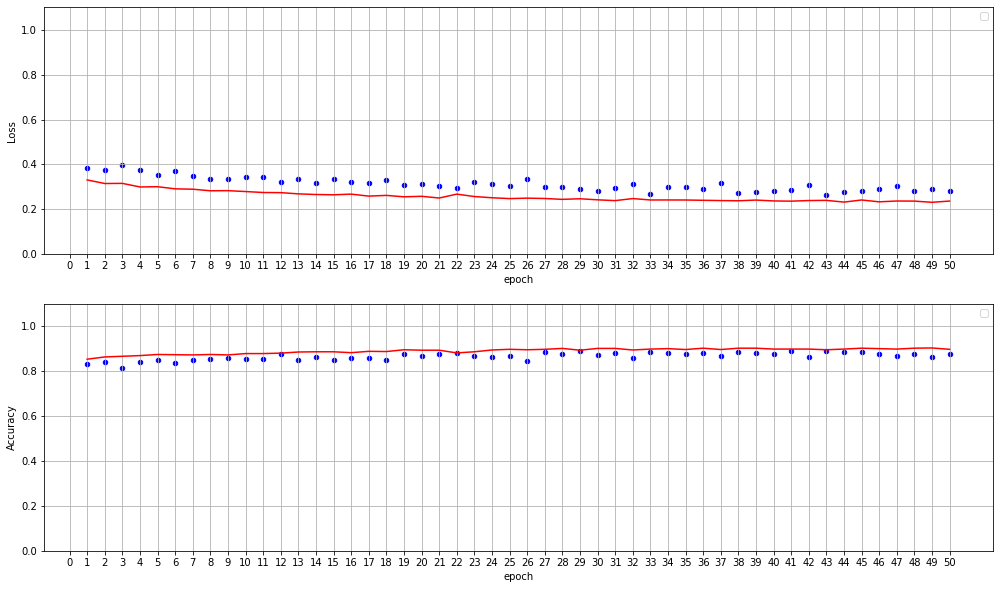

In [97]:
# MODEL 2: Evaluation
#####################
metrics_df = pd.DataFrame(history2b.history)
metrics_df['epoch'] = metrics_df.index+1
display(metrics_df.tail())

fig = plt.figure(figsize=(17,10))
ax1, ax2 = fig.add_subplot(2,1,1), fig.add_subplot(2,1,2)
metrics_df.plot(kind='scatter', x='epoch', y='loss', ax=ax1, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_loss', ax=ax1, label='validation', color='red',)
ax1.set_ylabel("Loss")
ax1.grid('GAINSBORO')
ax1.legend([])
ax1.set_ylim(0,1.1)
ax1.set_xticks(range(0,51))

metrics_df.plot(kind='scatter', x='epoch', y='accuracy', ax=ax2, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_accuracy', ax=ax2, label='validation', color='red',)
ax2.set_ylabel("Accuracy")
ax2.grid('GAINSBORO')
ax2.set_xticks(range(0,51))
ax2.legend([])
ax2.set_ylim(0,1.1)
plt.show()

In [98]:
# MODEL 3: Fine-Tuning
######################
conv_base_c = tf.keras.applications.VGG16(weights='imagenet', include_top=False, 
                                          input_shape=(150,150,3))
print(conv_base_c.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
# Only allow the final layer to be trained
conv_base_c.trainable = True
set_trainable = False

for layer in conv_base_c.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
model2c = tf.keras.models.Sequential()
model2c.add(conv_base_c)
model2c.add(tf.keras.layers.Flatten())
model2c.add(tf.keras.layers.Dense(256, activation='relu'))
model2c.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [102]:
# Train
model2c.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5), 
              loss='binary_crossentropy', metrics=['accuracy'])
with tf.device('/device:GPU:0'):
    history2c = model2c.fit(train_generator, epochs=50, batch_size=20,
                        steps_per_epoch=50,
          validation_data=validation_generator)

Epoch 1/50
50/50 [==============================] - 11s 226ms/step - loss: 0.5306 - accuracy: 0.7380 - val_loss: 0.3434 - val_accuracy: 0.8570
Epoch 2/50
50/50 [==============================] - 11s 222ms/step - loss: 0.4074 - accuracy: 0.8270 - val_loss: 0.2618 - val_accuracy: 0.8910
Epoch 3/50
50/50 [==============================] - 11s 219ms/step - loss: 0.3302 - accuracy: 0.8420 - val_loss: 0.2360 - val_accuracy: 0.9000
Epoch 4/50
50/50 [==============================] - 11s 220ms/step - loss: 0.3069 - accuracy: 0.8700 - val_loss: 0.2077 - val_accuracy: 0.9120
Epoch 5/50
50/50 [==============================] - 11s 222ms/step - loss: 0.2776 - accuracy: 0.8900 - val_loss: 0.2353 - val_accuracy: 0.9010
Epoch 6/50
50/50 [==============================] - 11s 221ms/step - loss: 0.2984 - accuracy: 0.8670 - val_loss: 0.2032 - val_accuracy: 0.9130
Epoch 7/50
50/50 [==============================] - 11s 224ms/step - loss: 0.2777 - accuracy: 0.8860 - val_loss: 0.1924 - val_accuracy: 0.9170

,loss,accuracy,val_loss,val_accuracy,epoch
45,0.078636,0.970,0.328210,0.921,46
46,0.095415,0.961,0.241738,0.932,47
47,0.073891,0.975,0.276778,0.928,48
48,0.080188,0.970,0.240959,0.933,49
49,0.058298,0.979,0.340845,0.913,50


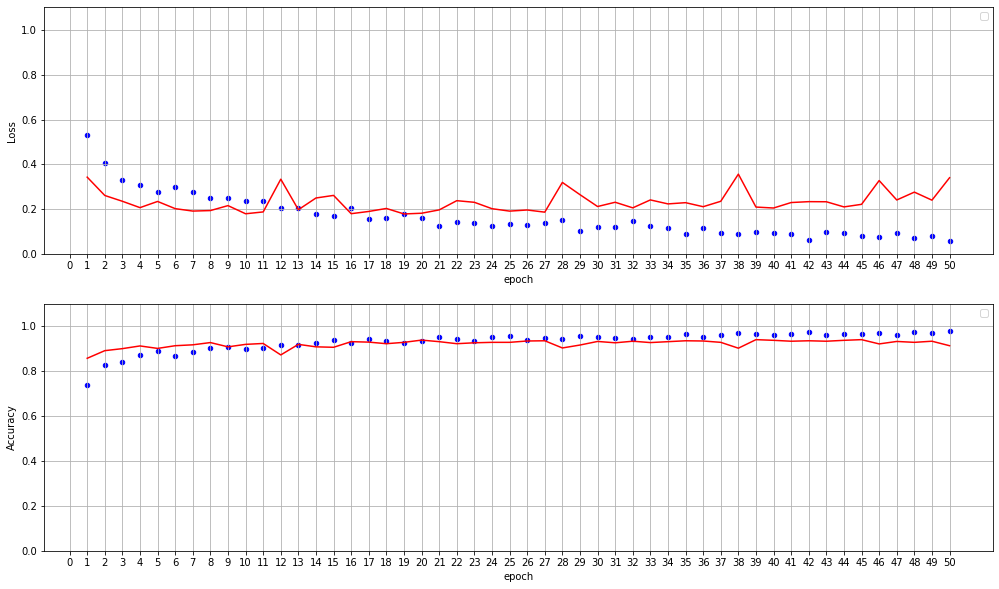

In [103]:
metrics_df = pd.DataFrame(history2c.history)
metrics_df['epoch'] = metrics_df.index+1
display(metrics_df.tail())

fig = plt.figure(figsize=(17,10))
ax1, ax2 = fig.add_subplot(2,1,1), fig.add_subplot(2,1,2)
metrics_df.plot(kind='scatter', x='epoch', y='loss', ax=ax1, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_loss', ax=ax1, label='validation', color='red',)
ax1.set_ylabel("Loss")
ax1.grid('GAINSBORO')
ax1.legend([])
ax1.set_ylim(0,1.1)
ax1.set_xticks(range(0,51))

metrics_df.plot(kind='scatter', x='epoch', y='accuracy', ax=ax2, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_accuracy', ax=ax2, label='validation', color='red',)
ax2.set_ylabel("Accuracy")
ax2.grid('GAINSBORO')
ax2.set_xticks(range(0,51))
ax2.legend([])
ax2.set_ylim(0,1.1)
plt.show()

In [104]:
# Test this on the test set
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150),
                                                   batch_size=20, class_mode='binary')

Found 1000 images belonging to 2 classes.


In [105]:
test_loss, test_acc = model2c.evaluate(test_generator, steps=50)
print(test_acc)

50/50 [==============================] - 3s 67ms/step - loss: 0.3031 - accuracy: 0.9150
0.9150000214576721
